In [5]:
import time
start_time = time.time()
import progressbar
import os
import numpy as np
from keras.preprocessing import image
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import stats
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [6]:
import landmarks_v2 as l2

In [7]:
def get_data():
    return l2.extract_features_labels()
    
def split_data(X, Y):

    X, Y = shuffle(X,Y)
    tr_X, te_X, tr_Y, te_Y = train_test_split(X, Y, train_size=0.7)
    
    return tr_X, tr_Y, te_X, te_Y

In [8]:
X,y = get_data()

print(X.shape)
print(y.shape)

(4800, 68, 2)
(4800,)


In [9]:
Y = np.array([y, -(y - 1)]).T 

tr_X, tr_Y, te_X, te_Y = split_data(X, Y)

In [10]:
print(tr_X.shape)
print(tr_Y.shape)
print(te_X.shape)
print(te_Y.shape)

(3360, 68, 2)
(3360, 2)
(1440, 68, 2)
(1440, 2)


In [11]:
def reshapeX(X):
    return X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

def reshapeY(y):
    return list(zip(*y))[0]

tr_X = reshapeX(tr_X)
te_X = reshapeX(te_X)
tr_Y = reshapeY(tr_Y)
te_Y = reshapeY(te_Y)

In [12]:
print(tr_X.shape)

(3360, 136)


In [11]:
gamma='scale'

for C in [0.1,1]:
    for degree in [1, 2, 3, 4]:
                
        lin_svc = svm.SVC(kernel='linear', C=C).fit(tr_X, tr_Y)
        print(C, "Linear:", lin_svc.score(te_X, te_Y))

        rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(tr_X, tr_Y)
        print( C, gamma, "Rbf:", rbf_svc.score(te_X, te_Y))

        poly_svc = svm.SVC(kernel='poly', degree=degree, C=C).fit(tr_X, tr_Y)
        print( C, degree, "Poly", poly_svc.score(te_X, te_Y))

0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 1 Poly 0.8604166666666667
0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 2 Poly 0.8763888888888889
0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 3 Poly 0.8958333333333334
0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 4 Poly 0.8951388888888889
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 1 Poly 0.8673611111111111
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 2 Poly 0.8895833333333333
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 3 Poly 0.8944444444444445
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 4 Poly 0.9027777777777778


In [13]:
from sklearn.svm import SVC as svc

In [14]:
lin = {'C': stats.uniform(1, 10), 'kernel': ['linear']}

rbf = {'C': stats.uniform(1, 10), 'gamma': stats.uniform(0.0001, 0.01), 'kernel': ['rbf']}

poly = {'C': stats.uniform(1, 10), 'degree': stats.uniform(1, 4), 'kernel': ['poly']}

def randomSearch(X, y, param_kernel):
    param_distributions = param_kernel 
    searchrand = RandomizedSearchCV(SVC(), param_distributions, n_iter=10, n_jobs=-1, refit=True, verbose=3)
    searchrand.fit(X, y)
#   printing statistical scores 
    searchrand.cv_results_
    
#    print(searchrand.cv_results_)
    return searchrand.best_params_, searchrand.best_estimator_  

# Obtaining optimum hyperparameters and classifier for different kernel
linSVC_param, lin_SVC = randomSearch(tr_X, tr_Y, lin)
rbfSVC_param, rbf_SVC = randomSearch(tr_X, tr_Y, rbf)
polySVC_param, poly_SVC = randomSearch(tr_X, tr_Y, poly)
#print(datetime.now() - start)

# Display optimum hyperparameters for SVC kernel
print('Optimum hyperparameters for linear kernel: ')
print(linSVC_param)
print('Optimum hyperparameters for rbf kernel: ')
print(rbfSVC_param)
print('Optimum hyperparameters for polynomial kernel: ')
print(polySVC_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.4s finished


Optimum hyperparameters for linear kernel: 
{'C': 4.8077154249836624, 'kernel': 'linear'}
Optimum hyperparameters for rbf kernel: 
{'C': 4.073436839025385, 'gamma': 0.001112757733775095, 'kernel': 'rbf'}
Optimum hyperparameters for polynomial kernel: 
{'C': 10.486069375573422, 'degree': 2.649313249416236, 'kernel': 'poly'}


In [15]:
# printing validation accuracy scores for each kernel
print(lin_SVC.score(te_X, te_Y))
print(rbf_SVC.score(te_X, te_Y))
print(poly_SVC.score(te_X, te_Y))

0.8888888888888888
0.89375
0.8875


Automatically created module for IPython interactive environment


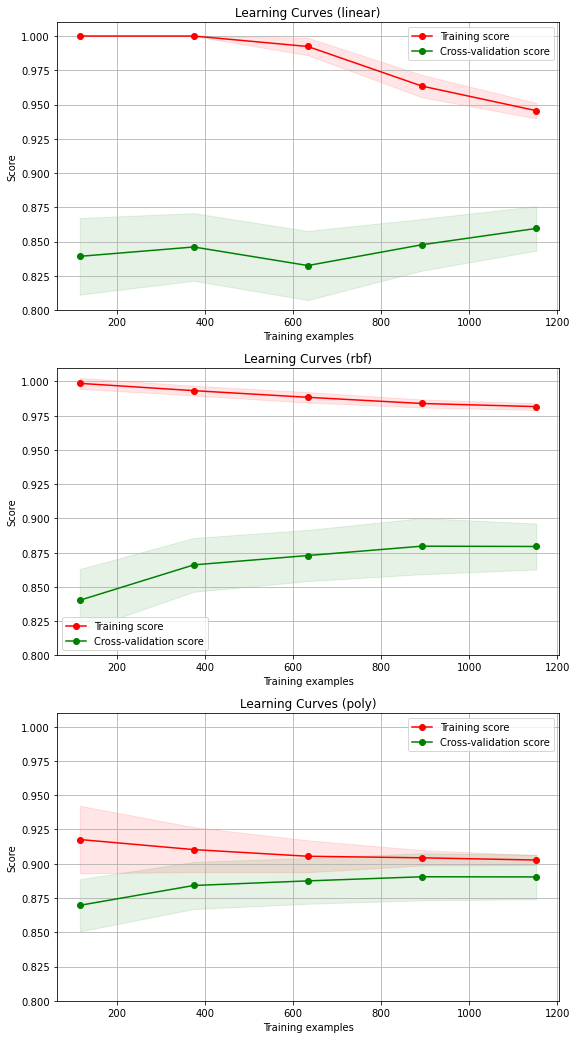

In [16]:
print(__doc__)


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
        axes.set_xlabel("Training examples")
        axes.set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
        axes.grid()
        axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        axes.legend(loc="best")

    return plt

plt.figure(figsize=(9,18))

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)


# estimator = poly_SVC 
# plot_learning_curve(estimator, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)
axes = plt.subplot(311)
title = r"Learning Curves (linear)"
plot_learning_curve(lin_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)

axes = plt.subplot(312)
title = r"Learning Curves (rbf)"
plot_learning_curve(rbf_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)

axes = plt.subplot(313)
title = r"Learning Curves (poly)"
plot_learning_curve(poly_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)


plt.show()

In [17]:
def val_sc(x):
    score = x.score(te_X, te_Y)
    return score

def tr_sc(x):
    score = x.score(tr_X, tr_Y)
    return score

In [18]:
val_sc = val_sc(rbf_SVC)
val_sc

0.89375

In [19]:
tr_sc = tr_sc(rbf_SVC)
tr_sc

0.9705357142857143

In [1]:
import landmarks_v2_test as l1 

Using TensorFlow backend.


In [2]:
def get_data():
    return l1.extract_features_labels()

In [3]:
A,b = get_data()

print(A.shape)
print(b.shape)

(969, 68, 2)
(969,)


In [20]:
B = np.array([b, -(b - 1)]).T
def reshapeX(A):
    return A.reshape((A.shape[0], A.shape[1] * A.shape[2]))

def reshapeY(b):
    return list(zip(*b))[0]

te_A = reshapeX(A)
te_B = reshapeY(B)

[[422  50]
 [ 50 447]]

Confusion Matrix


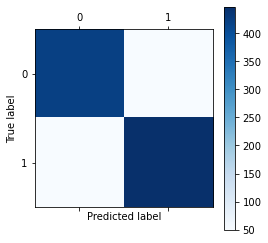

[[0.43550052 0.05159959]
 [0.05159959 0.46130031]]

Confusion Matrix(normalised)


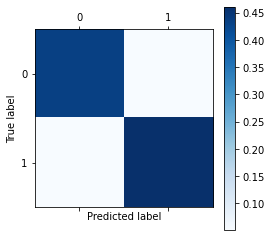

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       472
         1.0       0.90      0.90      0.90       497

    accuracy                           0.90       969
   macro avg       0.90      0.90      0.90       969
weighted avg       0.90      0.90      0.90       969

Accuracy achieved: 0.8968008255933952


In [32]:
op_lin_results = lin_SVC.predict(te_A)

cmap = plt.get_cmap('Blues')

cm = confusion_matrix(te_B, op_lin_results)
print(cm)
plt.matshow(cm)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')

plt.show()

cm2 = confusion_matrix(te_B, op_lin_results, normalize='all')
print(cm2)
plt.matshow(cm2)
plt.imshow(cm2, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix(normalised)')
plt.show()

print(classification_report(te_B, op_lin_results))
print('Accuracy achieved:', accuracy_score(te_B, op_lin_results))

[[417  55]
 [ 56 441]]

Confusion Matrix


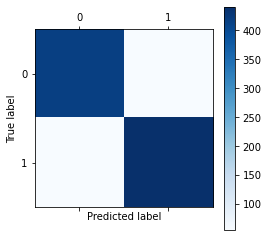

[[0.43034056 0.05675955]
 [0.05779154 0.45510836]]

Confusion Matrix(normalised)


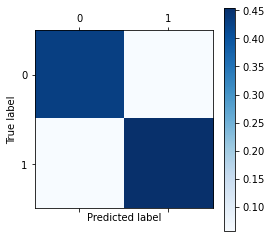

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       472
         1.0       0.89      0.89      0.89       497

    accuracy                           0.89       969
   macro avg       0.89      0.89      0.89       969
weighted avg       0.89      0.89      0.89       969

Accuracy achieved: 0.8854489164086687


In [33]:
op_rbf_results = rbf_SVC.predict(te_A)
cmap = plt.get_cmap('Blues')
cm = confusion_matrix(te_B, op_rbf_results)
print(cm)
plt.matshow(cm)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()

cm2 = confusion_matrix(te_B, op_rbf_results, normalize='all')
print(cm2)
plt.matshow(cm2)
plt.imshow(cm2, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix(normalised)')
plt.show()

print(classification_report(te_B, op_rbf_results))
print('Accuracy achieved:', accuracy_score(te_B, op_rbf_results))

[[429  43]
 [ 48 449]]

Confusion Matrix


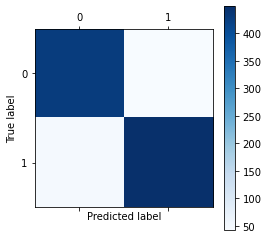

[[0.44272446 0.04437564]
 [0.0495356  0.46336429]]

Confusion Matrix(normalised)


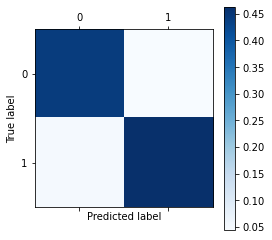

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       472
         1.0       0.91      0.90      0.91       497

    accuracy                           0.91       969
   macro avg       0.91      0.91      0.91       969
weighted avg       0.91      0.91      0.91       969

Accuracy achieved: 0.9060887512899897


In [34]:
op_p_results = poly_SVC.predict(te_A)
cmap = plt.get_cmap('Blues')
cm = confusion_matrix(te_B, op_p_results)
print(cm)
plt.matshow(cm)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()

cm2 = confusion_matrix(te_B, op_p_results, normalize='all')
print(cm2)
plt.matshow(cm2)
plt.imshow(cm2, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix(normalised)')
plt.show()

print(classification_report(te_B, op_p_results))
print('Accuracy achieved:', accuracy_score(te_B, op_p_results))

In [24]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2052.5903074741364 seconds ---
